In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

Run the `dj_mix_analyzer.py` script to analyze some DJ mixes.

Then fill out the output directory of that script here, as well as the key used in the feature dict of the desired features, to use this notebook with those features:

In [2]:
dir_ = 'output'
feature_keys = ['percussive_density', 'harmonic_density']

In [3]:
npzs_names = [f for f in sorted(os.listdir(dir_))]
npzs = [np.load(os.path.join(dir_, f),allow_pickle=True)['arr_0'] for f in sorted(os.listdir(dir_))]
features = {feature_key : [z.item()[feature_key] for z in npzs] for feature_key in feature_keys}
print(f'Loaded {len(features)} features for {len(features[feature_keys[0]])} mixes!')

Loaded 2 features for 83 mixes!


Post processing of the feature arrays: smoothing them out (experimental):

In [4]:
def running_mean(x, N):
    return np.convolve(x, np.ones(N)/N, mode='valid')

for k in feature_keys:
    features[k] = [running_mean(f, 15) for f in features[k]]

Post processing of the feature arrays: zero mean

In [5]:
for k in feature_keys:
    features[k] = [f - np.mean(f) for f in features[k]]

All feature arrays have a different length, because the mixes have different lengths. Let's see just how different:

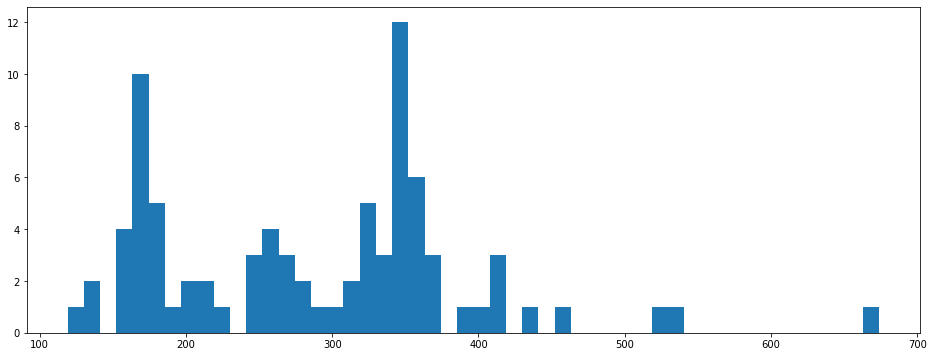

In [6]:
plt.figure(figsize=(16,6))
plt.hist([len(f) for f in features[feature_keys[0]]], bins=50);

We'll have to get these arrays into equal length arrays, in order to perform PCA over the "standardized-length feature evolution" arrays.

In [7]:
def feature_array_to_length(f, N):
    return np.interp(np.linspace(0, len(f)-1, N), np.linspace(0, len(f)-1, len(f)), f)

In [8]:
features_equallength = {}
L = int(np.median([len(f) for f in features[feature_keys[0]]]))
print(f'Setting lengths of feature arrays to {L}')
for k in feature_keys:
    features_equallength[k] = [feature_array_to_length(f, L) for f in features[k]]
    features_equallength[k] = np.array(features_equallength[k])
    print(features_equallength[k].shape)

Setting lengths of feature arrays to 303
(83, 303)
(83, 303)


In [9]:
import sklearn
from sklearn.decomposition import PCA as PCA_

PCAs = {}
features_new = {}
N_comp_PCA = 10

for k in feature_keys:
    PCAs[k] = PCA_(n_components=N_comp_PCA)
    features_new[k] = PCAs[k].fit_transform(features_equallength[k])

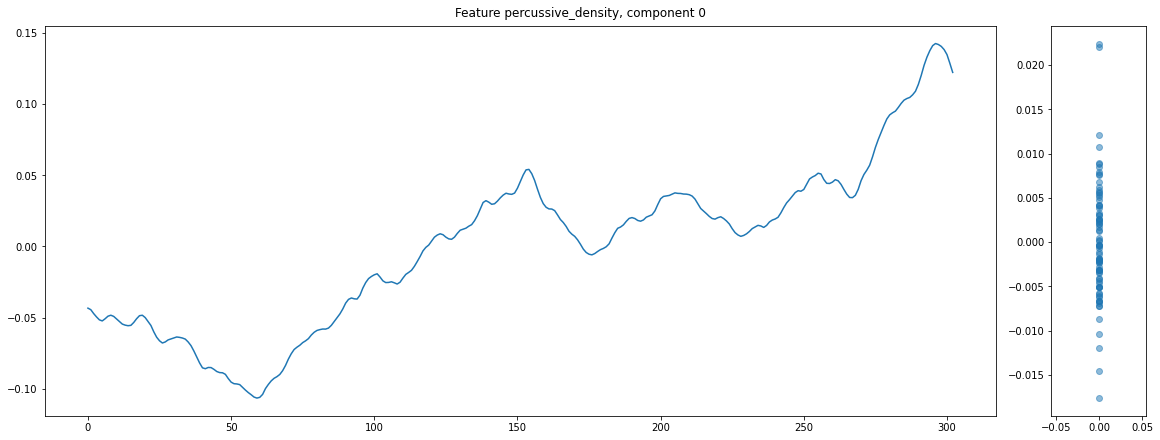

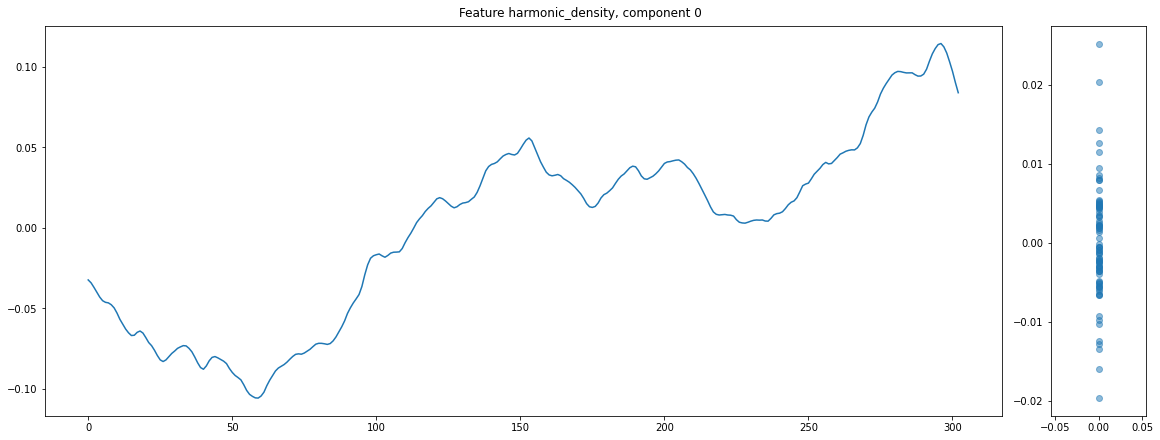

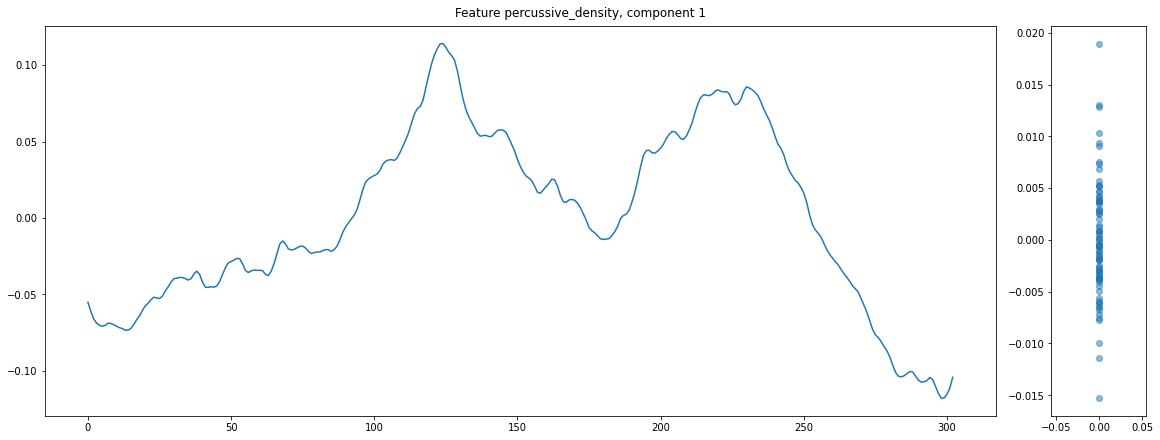

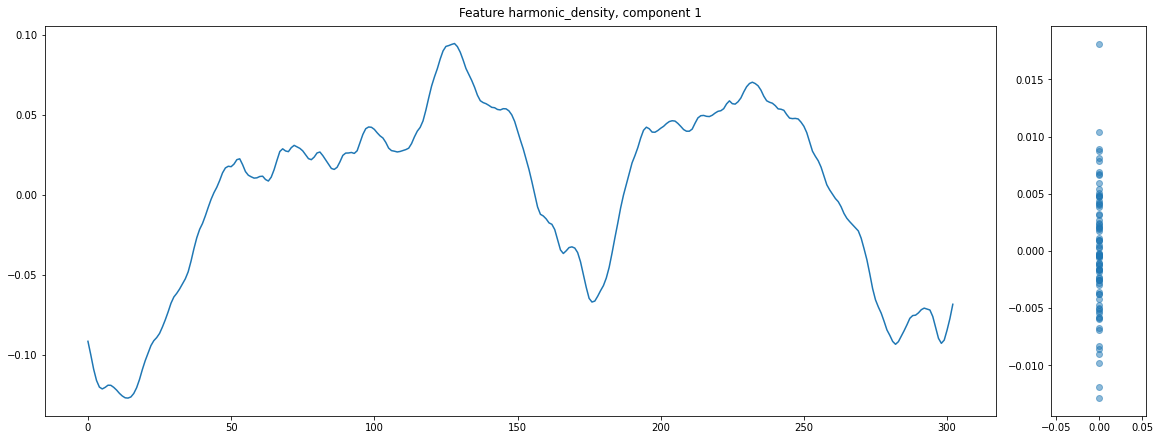

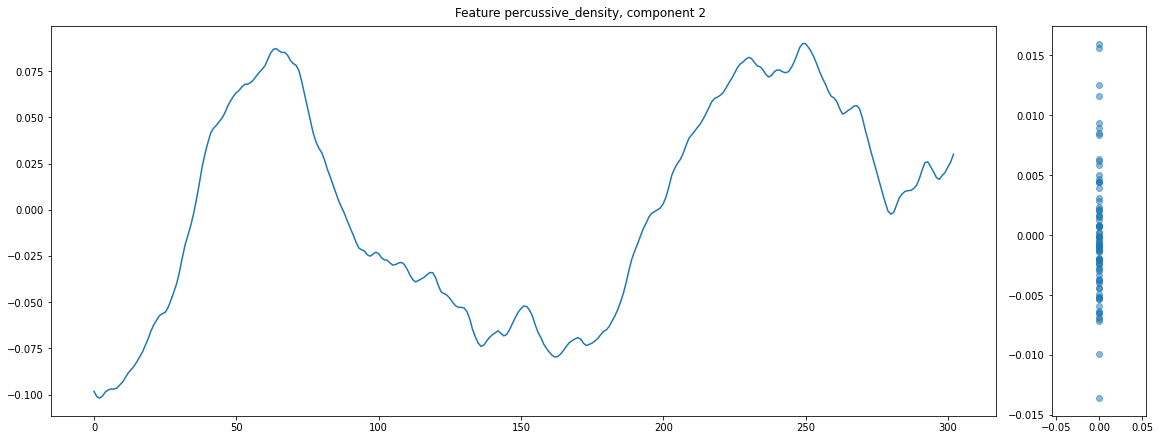

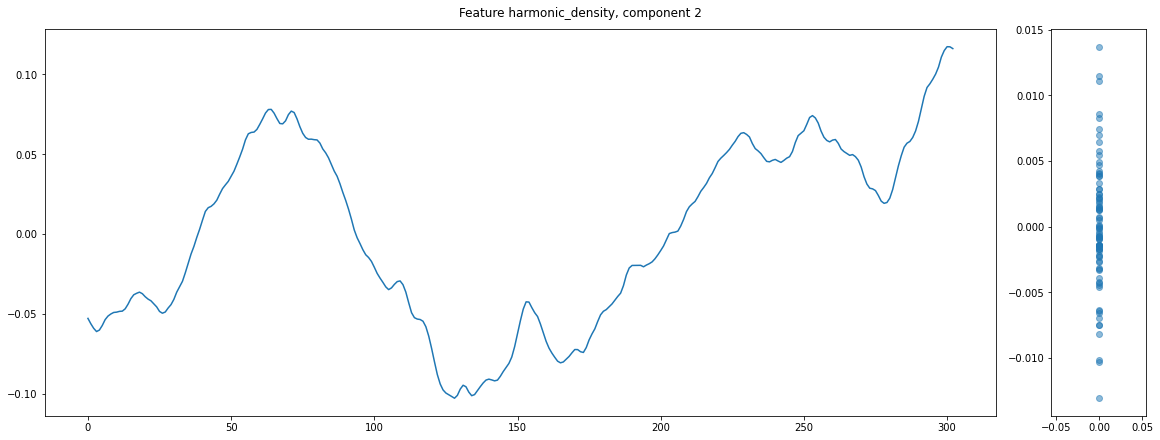

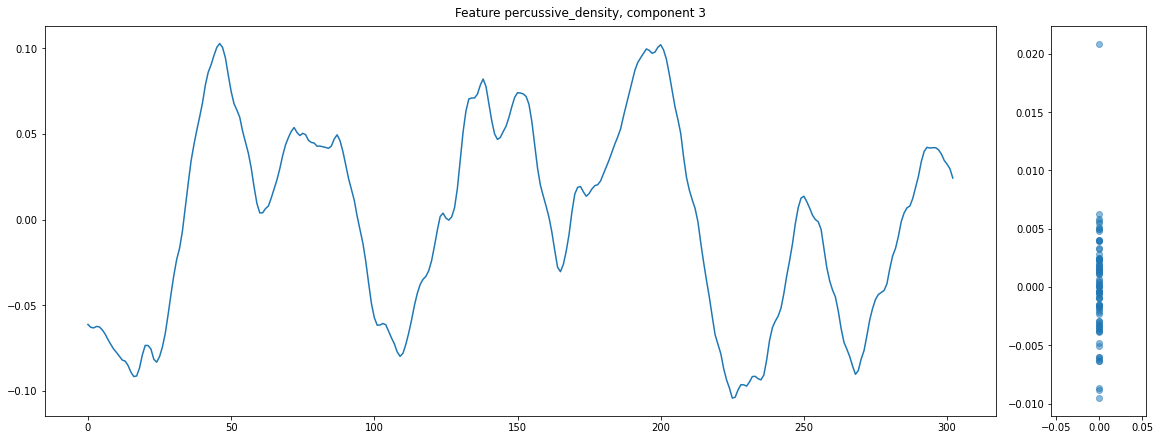

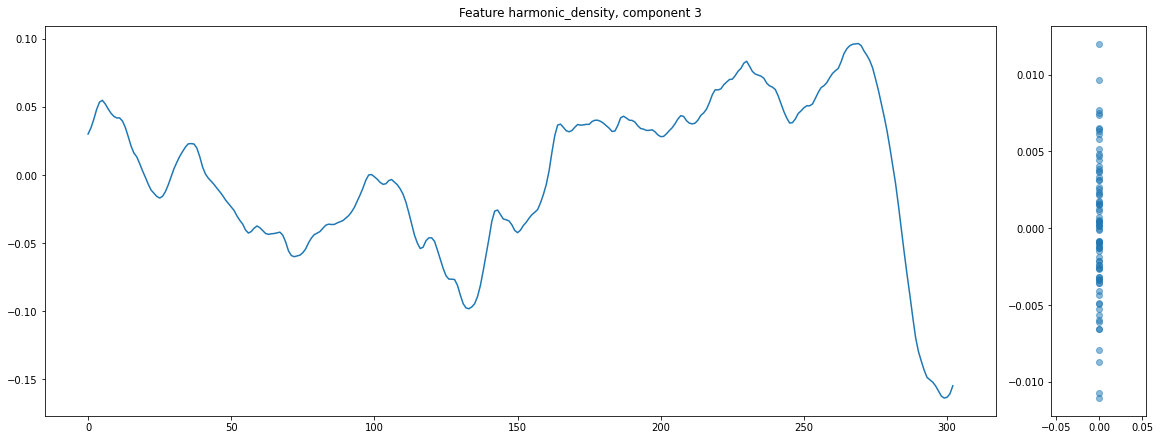

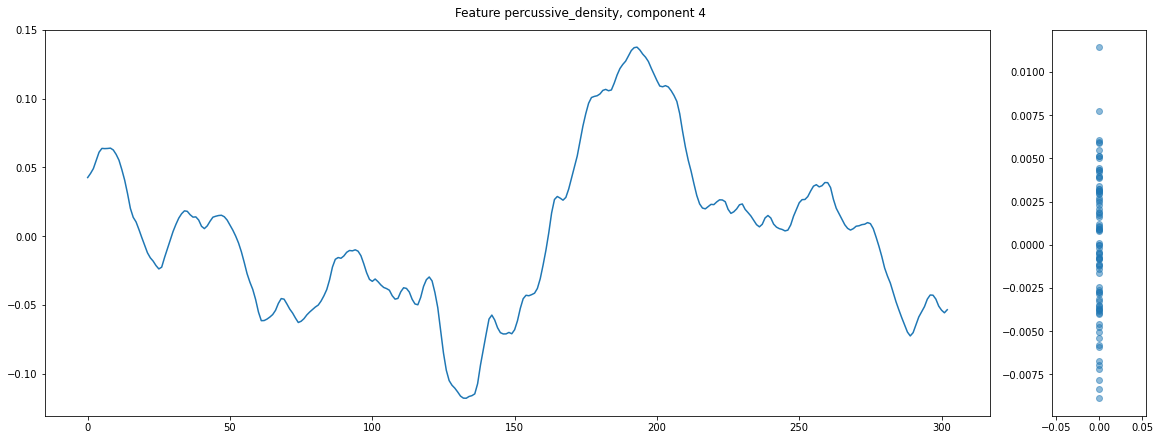

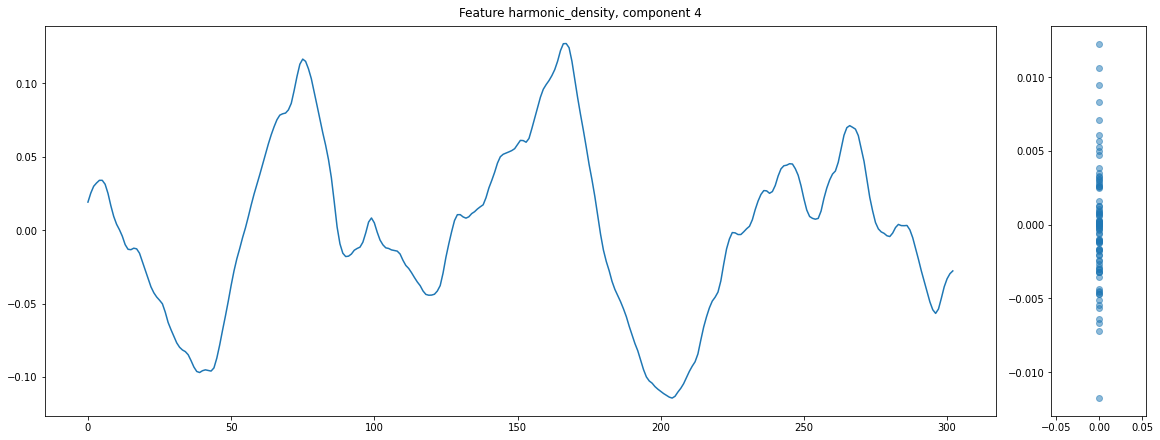

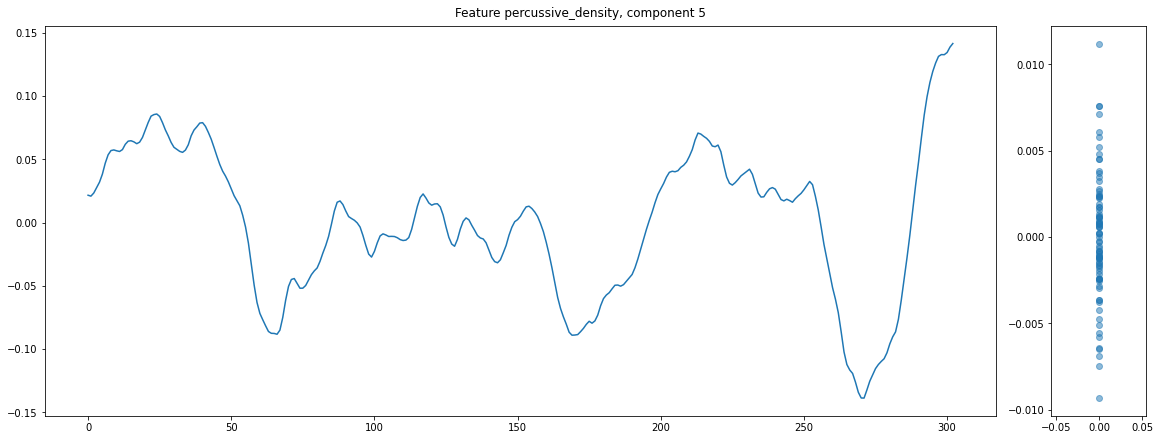

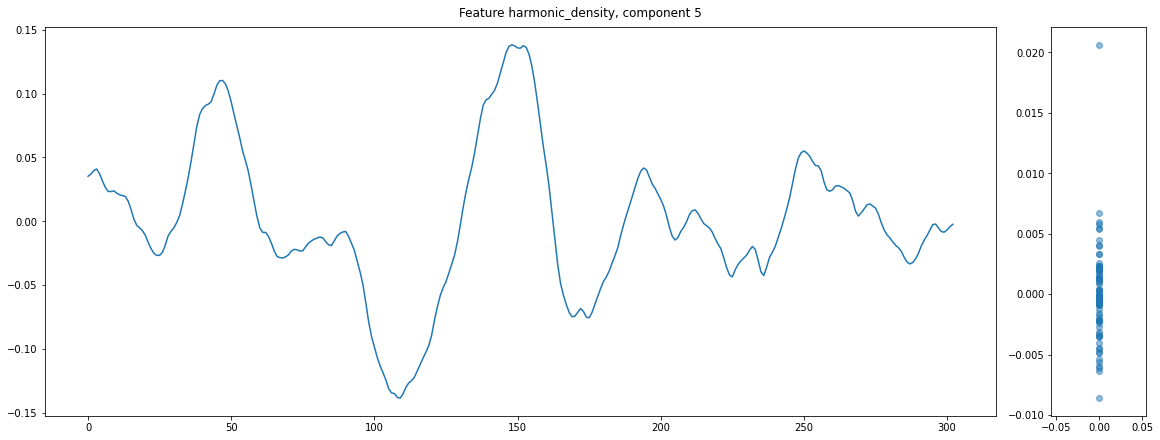

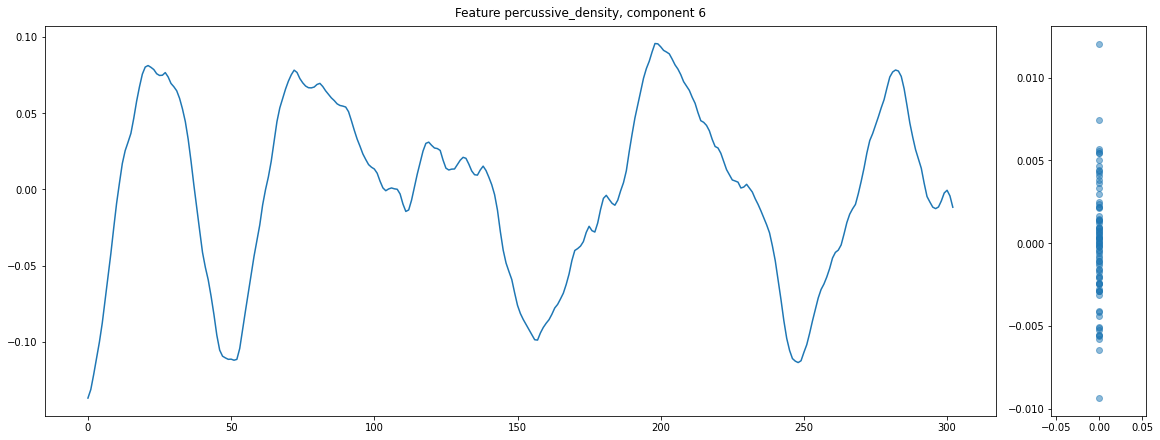

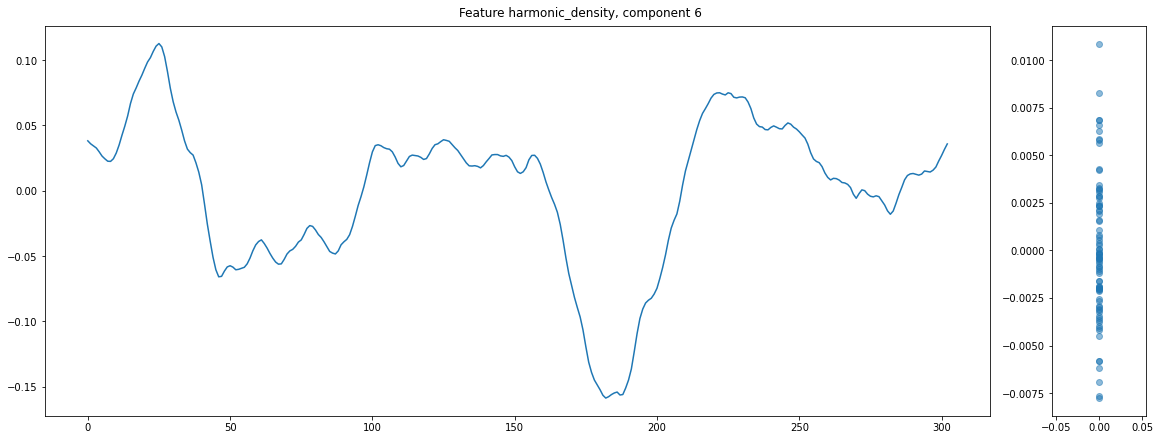

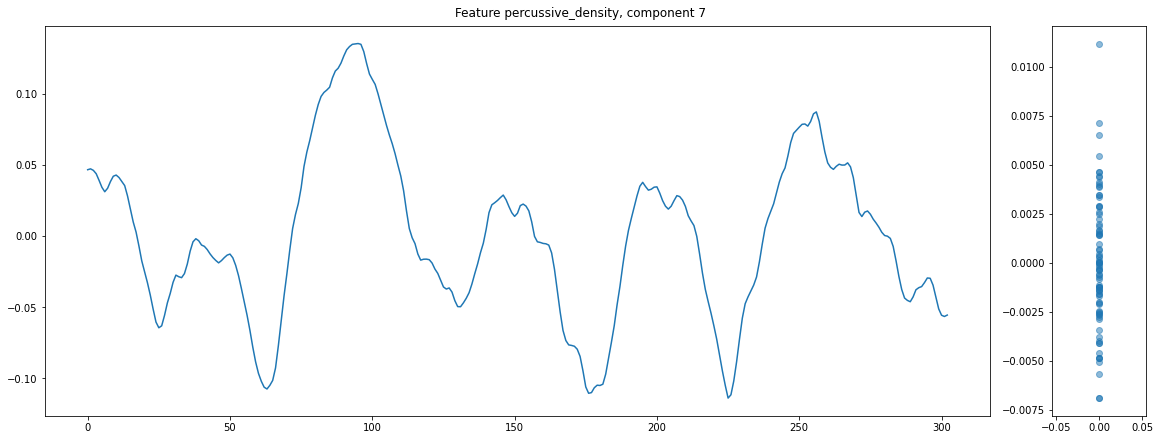

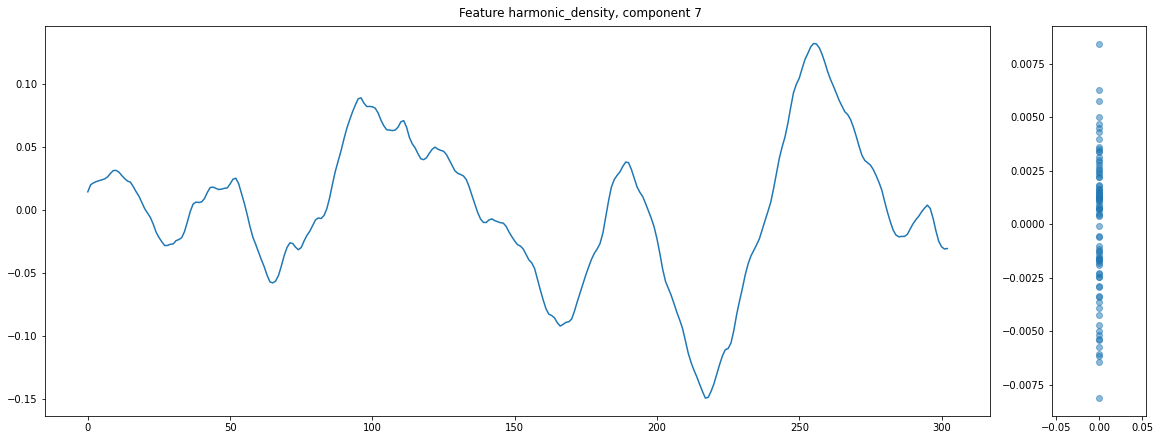

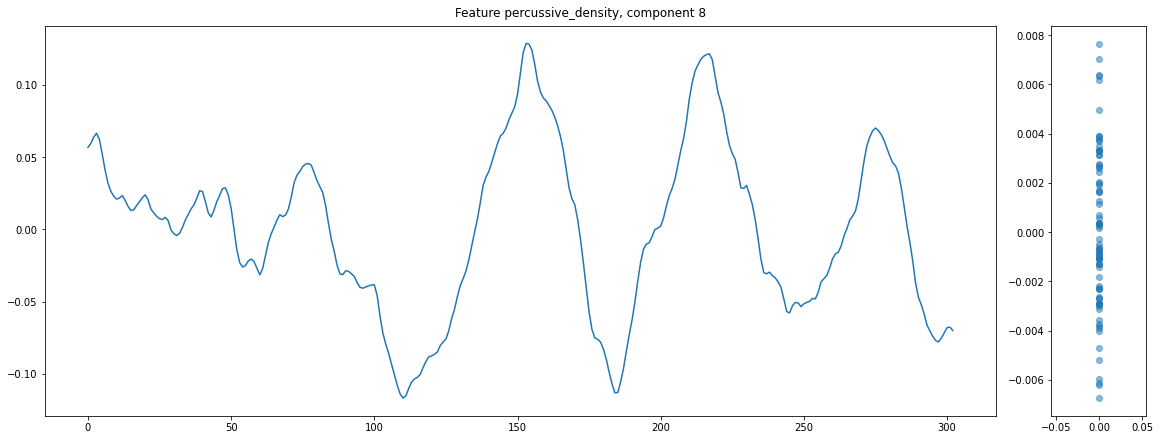

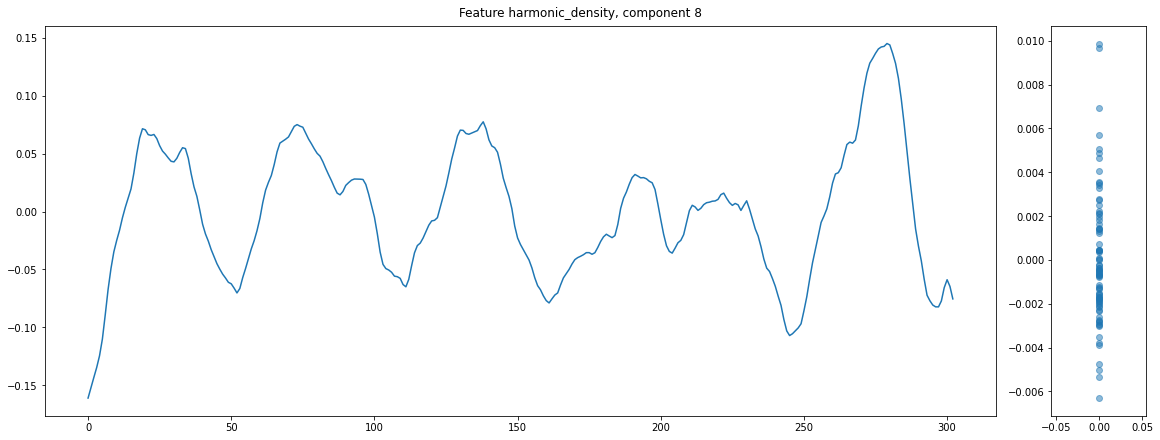

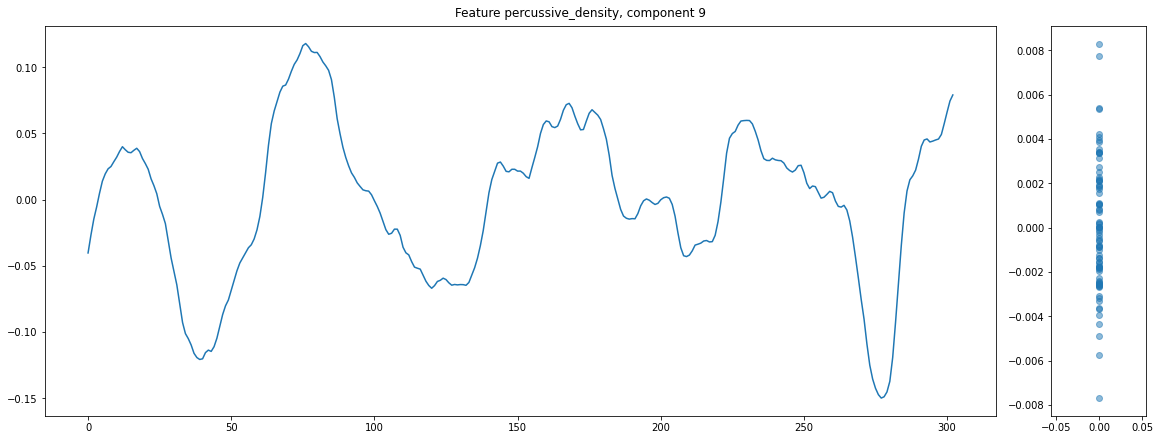

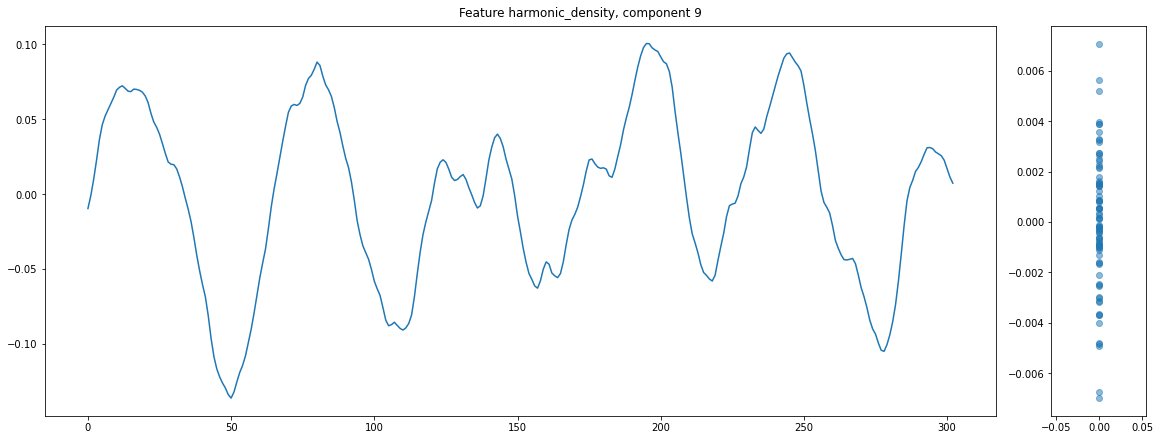

In [10]:
for i in range(N_comp_PCA):
    for k in feature_keys:
        
        comp = PCAs[k].components_
        c = comp[i]
        
        gs_kw = {'width_ratios' : [10,1]}
        fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, gridspec_kw=gs_kw, figsize=(16,6))
        axes[0].plot(c)
        axes[1].scatter(np.zeros_like(features_new[k][:, i]), features_new[k][:, i], alpha=0.5)
        plt.suptitle(f'Feature {k}, component {i}')

Plot the top 3 mixes for component 0.
For each of these mixes, also plot the contribution of the component with the second highest contribution to that mix's progression.

In [11]:
for k in feature_keys:
    for i, var_ in enumerate(PCAs[k].explained_variance_):
        print(f'Feature {k}, PCA component {i} explained variance: {var_:.5f}')

Feature percussive_density, PCA component 0 explained variance: 0.00004
Feature percussive_density, PCA component 1 explained variance: 0.00003
Feature percussive_density, PCA component 2 explained variance: 0.00003
Feature percussive_density, PCA component 3 explained variance: 0.00002
Feature percussive_density, PCA component 4 explained variance: 0.00002
Feature percussive_density, PCA component 5 explained variance: 0.00001
Feature percussive_density, PCA component 6 explained variance: 0.00001
Feature percussive_density, PCA component 7 explained variance: 0.00001
Feature percussive_density, PCA component 8 explained variance: 0.00001
Feature percussive_density, PCA component 9 explained variance: 0.00001
Feature harmonic_density, PCA component 0 explained variance: 0.00005
Feature harmonic_density, PCA component 1 explained variance: 0.00003
Feature harmonic_density, PCA component 2 explained variance: 0.00002
Feature harmonic_density, PCA component 3 explained variance: 0.00002


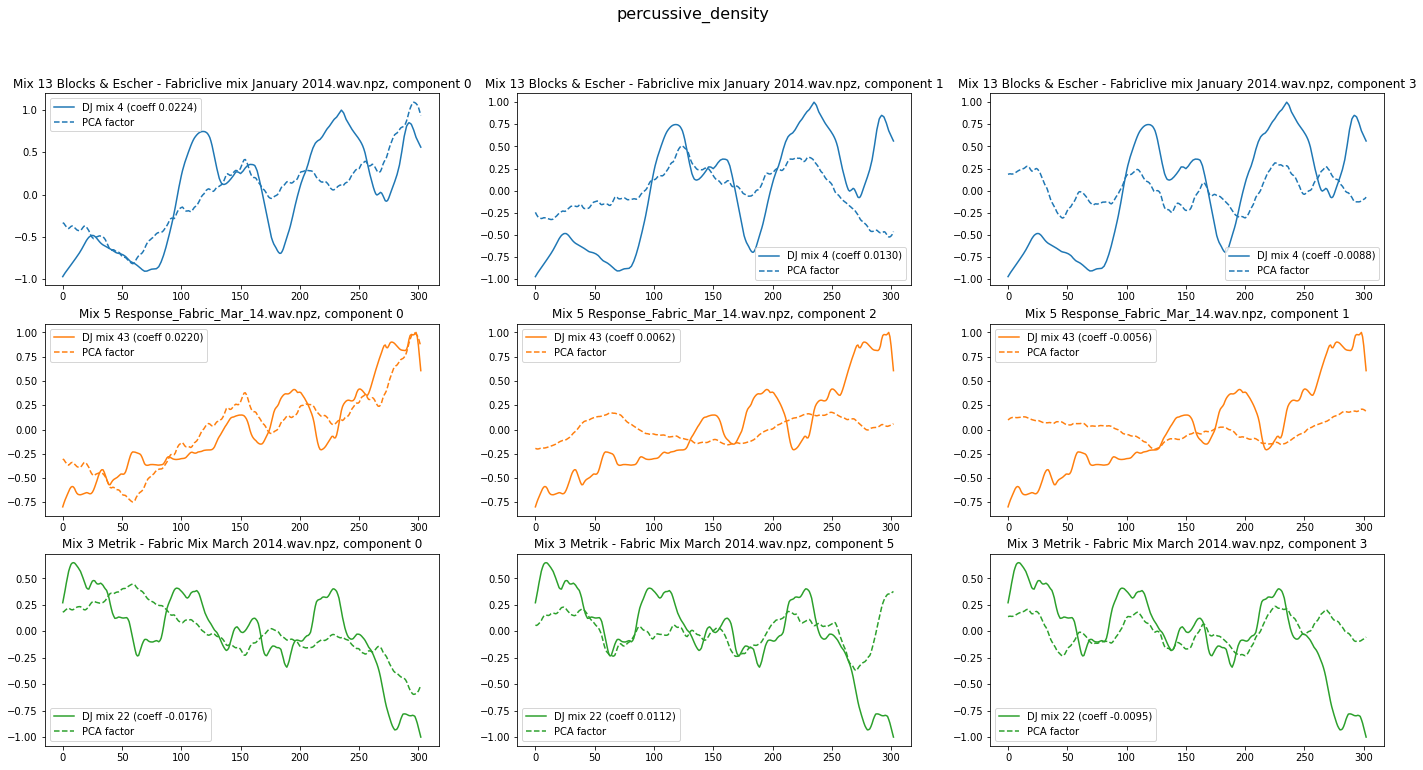

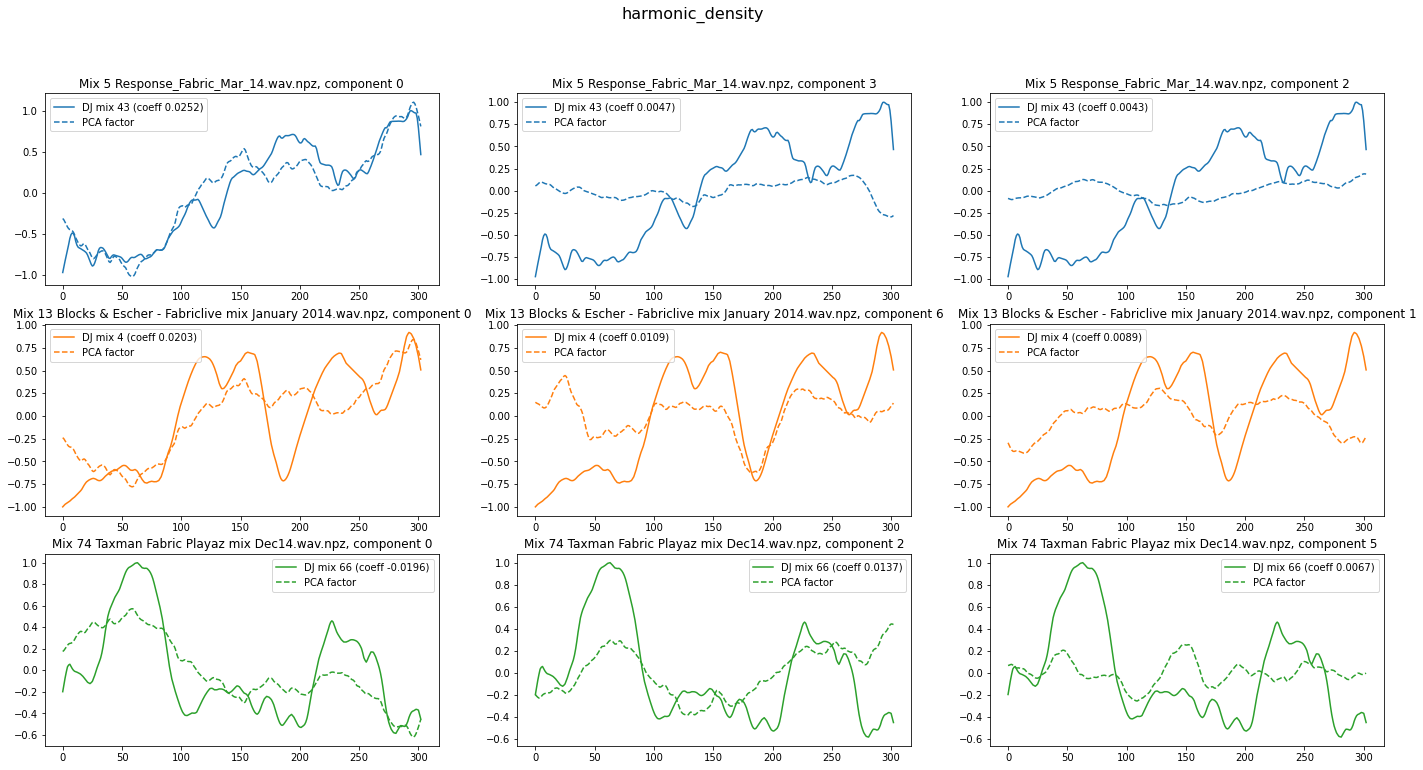

In [12]:
for k in feature_keys:
    
    comp = PCAs[k].components_

    N_comps = 3  # Plot these PCA componets
    N_mixes = 3 # Plot 3 mixes
    component_to_sort_by = 0

    plt.figure(figsize=(N_comps * 8, N_mixes * 4))
    plt.suptitle(k, fontsize=16)

    mixes_sorted = np.argsort(np.abs(features_new[k][:, component_to_sort_by]))


    # Plot the top 5 mixes for this component, alongside the other two components
    for j, i_mix in enumerate(mixes_sorted[-N_mixes:][::-1]):

        components_sorted_mix_i = np.argsort(np.abs(features_new[k][i_mix, :]))
        components_sorted_mix_i = np.delete(components_sorted_mix_i, 
                                            np.where(components_sorted_mix_i == component_to_sort_by)
                                           )

        for i in range(N_comps):      

            if i != 0:
                # For this mix, find the component that has the second/third/... highest 
                # contribution to this mix's progression
                i_comp = components_sorted_mix_i[-i]
            else:
                i_comp = component_to_sort_by

            plt.subplot(N_mixes, N_comps, 1 + i + N_comps*j)
            y = features_equallength[k][i_mix]
            plt.plot( y / np.max(np.abs(y)), label=f'DJ mix {i_mix} (coeff {features_new[k][i_mix, i_comp]:.4f})', c=f'C{j}')
            plt.plot( features_new[k][i_mix, i_comp] * comp[i_comp] / np.max(np.abs(y)), c=f'C{j}', label='PCA factor', linestyle='--')
            plt.title(f'Mix {npzs_names[i_mix]}, component {i_comp}')
            plt.legend()

## Interactively exploring the features

This part of the notebook allows you to explore the feature arrays of the DJ mixes (extracted using the `dj_mix_analyzer.py` script) while listening to the DJ mix.

In [ ]:
import ipywidgets as widgets
import plotly.graph_objects as go
import plotly.express as px
colorscale = px.colors.sequential.Inferno
from IPython.display import Audio

In [ ]:
mixes_dir = 'PATH/TO/THE/MIXES/DIRECTORY/HERE'

files = [os.path.join(mixes_dir,f) for f in sorted(os.listdir(mixes_dir))]
names = list(sorted(os.listdir(mixes_dir)))
    
d = widgets.Dropdown(
    options=list(zip(names, files)),
    description='Input DJ mix:',
)
d

In [ ]:
a = Audio(filename=f'{d.value}', element_id='audio')
display(a)

Execute the cell below to show a plot of the loaded features for the selected mix.  
_After the plot has loaded (important!)_, execute the cell below that to make the plot interactive: clicking the plot will move the audio playback location to the part of the mix that you clicked on.

In [ ]:
out = widgets.Output()
# @out.capture(clear_output=True)
# def callback_click(trace, points, selector):
#     if len(points.point_inds) > 0:
#         t_sec = (points.point_inds[0] * hop_length / sr)
#         print(f'Resuming playback at {t_sec // 60:.0f}:{t_sec % 60:02.0f}.')

# x scale :time in secondsspectral
# scaled_x = np.linspace(0,len(feature) * hop_length / sr / 60.0,len(feature))

# in valid convolution to smooth features, we're losing beginning and end of feature array
fraction_not_plotted = 15 / (len(features[feature_keys[0]][d.index])+15)
scaled_x = np.linspace(fraction_not_plotted, 1 - fraction_not_plotted, L)

fig = go.FigureWidget()

def normalized(x):
    return x / np.max(x)

for i,feature_name in enumerate(feature_keys):
    fig.add_trace(go.Scatter(
            x=scaled_x, y=normalized(features_equallength[feature_name][d.index]),
            hoverinfo='x+y',
            mode='lines',
            line=dict(width=1.0, color=colorscale[5+i]),
            #stackgroup='one', # define stack group,
            name=f'{feature_name}'
        ))

for i in range(len(fig.data)):
    scatter = fig.data[i]
#     scatter.on_click(callback_click)
widgets.VBox([fig, out])

Execute this cell only after the plot above has loaded (otherwise the JavaScript code below won't find the right element to bind to, breaking the interactivity of the plot/audio playback).

In [ ]:
%%javascript

if(executedjs == null){
    var audioplayer = $("audio")[0];
    // If it exists, bind javascript to plotly
    var plotlyPlots = $('.js-plotly-plot');
    console.log('Found audio player and plotly: ' + (audioplayer) + '; ' + (plotlyPlots))

    for(var i=0; i<plotlyPlots.length; i++){
        let p = plotlyPlots[i];
        p.on('plotly_click', function(data){
            var x = data.points[0].x
            console.log('Clicked on '+x);
            audioJumpTo(x);
        });
    }

    function audioJumpTo(time_as_ratio){
        // Jump to a time in the audio
        //   time_to_ratio should be a _relative_ starting point,
        //   0.0 being the start of the audio, 0.5 being halfway, 1.0 being the end.
        var time = time_as_ratio * audioplayer.duration;
        console.log('Current time of audio: ' + audioplayer.currentTime);
        console.log('Duration of audio: ' + audioplayer.duration);
        audioplayer.currentTime = time;
        console.log('Set time of audio to ' + audioplayer.currentTime);
    }

    function audioSeek(amount){
        // Jump forwards or backwards in the music by increments of "amount" seconds. Amount can be negative.
        console.log('Current time of audio: ' + audioplayer.currentTime);
        audioplayer.currentTime += amount; 
        console.log('Set time of audio to ' + audioplayer.currentTime);
    }
} else {
    console.log('Not reexecuting js...');
}
var executedjs = true;